In [1]:
import torch 
import torch.nn as nn 
from fastai.vision.all import *

## VAE

In [2]:
import torch
from torch import nn


class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        x = x.view(x.shape[0], -1)
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma

## DataBlock

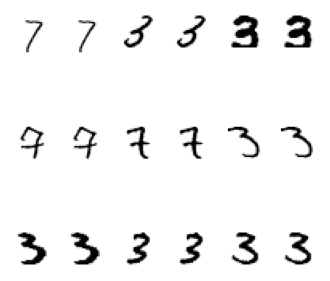

In [3]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  )
dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

## Loss Function

In [4]:
BCE_loss = nn.BCELoss(reduction='sum')
def loss_fn(output, x):
    x_reconstructed, mu, sigma = output
    x = x.view(x.shape[0], -1)
    BCE = BCE_loss(x_reconstructed, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

    return BCE + KLD

## Build Learner

In [5]:
my_learner = Learner(dls,
                     VariationalAutoEncoder(784),
                     loss_func=loss_fn)
my_learner.fit_one_cycle(200)

epoch,train_loss,valid_loss,time
0,41282.089844,40651.425781,00:00
1,41064.136719,40287.781250,00:00
2,40830.226562,39900.460938,00:00
3,40585.179688,39456.406250,00:00
4,40325.441406,39052.480469,00:00
5,40039.082031,38554.347656,00:00
6,39712.421875,37999.292969,00:00
7,39332.777344,37324.023438,00:00
8,38880.992188,36462.617188,00:00
9,38329.894531,35382.968750,00:00


## Show results

In [6]:
x, y = my_learner.dls.one_batch()
preds, targs = my_learner.get_preds(dl=[(x[0], y[0])])
x_reconstructed, mu, sigma = preds
x_reconstructed = x_reconstructed.reshape(1,28,28)

# Transform to PIL format for display
import torchvision.transforms as T

transform = T.ToPILImage()
img_targs = transform(targs)
img_reconstructed = transform(x_reconstructed)

img_targs.show()
img_reconstructed.show()

## Trivial

In [ ]:
# Save images
from torchvision.utils import save_image
save_image(targs, 'img1.png')

In [7]:
# See type and shape
print(f'{type(x) = },\n{len(x) = } ,\n{x[0].shape = }')
print(f'{type(y) = },\n{len(y) = } ,\n{y[0].shape = }')

type(x) = <class 'fastai.torch_core.TensorImageBW'>,
len(x) = 64 ,
x[0].shape = torch.Size([1, 28, 28])
type(y) = <class 'fastai.torch_core.TensorImageBW'>,
len(y) = 64 ,
y[0].shape = torch.Size([1, 28, 28])
